<a href="https://colab.research.google.com/github/hyungchanchoi/AlgorithmTrading_pykiwoom/blob/main/data%20analysis/_kodex200_kodex_inv_analy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# import os, sys
# from google.colab import drive
# drive.mount('/content/drive')
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from datetime import datetime,timedelta
from sklearn.preprocessing import minmax_scale
from statsmodels.tsa.stattools import coint
today = datetime.today().strftime("%Y%m%d") 
# start = (datetime.today() - timedelta()).strftime("%Y%m%d") 
# print(start, today)
pd.options.display.float_format = '{:.6f}'.format

In [2]:
cd drive/My Drive/algorithmtrading/pair_trading/Datas

/content/drive/My Drive/algorithmtrading/pair_trading/Datas


In [2]:
def one_day(temp,test_day):
    
    begin = np.where( np.array(temp.index) > str(test_day))[0][0]
    end = np.where( str(test_day+1) > np.array(temp.index) )[0][-1]
    
    if len(temp.iloc[begin:end])==0:
        print(test_day,'는 공휴일 입니다.')
    else:
        return temp.iloc[begin:end]

# - 과거 1분단위 데이터 받아오기

In [9]:
now = '20210117'

kodex200 = pd.read_pickle('KODEX 200(m)_'+now)
kodex_inv = pd.read_pickle('KODEX 인버스(m)_'+now)

temp =  pd.merge(left = kodex200 , right = kodex_inv, how = "inner", on = "체결시간")
temp = temp.set_index('체결시간')
temp.columns = ['kodex200','volume','kodex_inv','volume']
temp = temp[['kodex200','kodex_inv']]

temp['kodex200']=pd.to_numeric(temp['kodex200'])
temp['kodex_inv']=pd.to_numeric(temp['kodex_inv'])

temp['kodex200']=abs(temp['kodex200'])
temp['kodex_inv']=abs(temp['kodex_inv'])

temp['kodex_inv_cumret'] = np.log(temp['kodex_inv']/temp['kodex_inv'][0])
temp['kodex200_cumret'] = np.log(temp['kodex200']/temp['kodex200'][0])

temp['kodex_inv'] = temp['kodex_inv']
temp['spread'] = temp['kodex200'] + temp['kodex_inv']
temp['ma60_spread'] = temp['spread'].rolling(window=10, center=False).mean()

temp

,kodex200,kodex_inv,kodex_inv_cumret,kodex200_cumret,spread,ma60_spread
체결시간,,,,,,
20200102100000,29221,6345,0.000000,0.000000,35566,nan
20200102100100,29192,6345,0.000000,-0.000993,35537,nan
20200102100200,29206,6345,0.000000,-0.000513,35551,nan
20200102100300,29192,6345,0.000000,-0.000993,35537,nan
20200102100400,29152,6355,0.001575,-0.002364,35507,nan
...,...,...,...,...,...,...
20210115151600,42605,3935,-0.477756,0.377084,46540,46553.000000
20210115151700,42620,3935,-0.477756,0.377436,46555,46550.500000
20210115151800,42610,3930,-0.479028,0.377201,46540,46543.000000


 # - 공적분 확인

In [6]:
x = coint(temp['kodex200'][-1000:],temp['kodex_inv'][-1000:])
x

(-6.804670480314079,
 2.483669019063119e-08,
 array([-3.90743646, -3.34225305, -3.04869817]))

# - 일 단위로 데이터 저장하기 + 당일 수익률 계산

In [12]:
df = {}
calender = []
for date in range(20210101,20210115):
    if 20201231 < date < 20210100:
        continue
    temps = pd.DataFrame()
    temps = one_day(temp,date)
    try:      
        temps['kodex_inv_dayret'] = np.log(temps['kodex_inv']/temps['kodex_inv'][0])
        temps['kodex200_dayret'] = np.log(temps['kodex200']/temps['kodex200'][0])
        temps['spread_cumret'] = temps['kodex_inv_cumret'] -temps['kodex200_cumret']
        temps['spread_dayret']= temps['kodex_inv_dayret'] - temps['kodex200_dayret'] 
        temps['ma60_spread'] = temps['spread'].rolling(window=10, center=False).mean()
        temps['std60_spread'] = temps['spread'].rolling(window=20, center=False).mean()
        temps['zscore'] = (temps['spread'] - temps['ma60_spread']) / temps['std60_spread']
        df[str(date)] = temps
        if len(temps) != 0:
            calender.append(str(date))
    except:
        pass
calender

20210101 는 공휴일 입니다.
20210102 는 공휴일 입니다.
20210103 는 공휴일 입니다.
20210109 는 공휴일 입니다.
20210110 는 공휴일 입니다.


['20210104',
 '20210105',
 '20210106',
 '20210107',
 '20210108',
 '20210111',
 '20210112',
 '20210113',
 '20210114']

In [14]:
df['20210114']

,kodex200,kodex_inv,kodex_inv_cumret,kodex200_cumret,spread,ma60_spread,kodex_inv_dayret,kodex200_dayret,spread_cumret,spread_dayret,std60_spread,zscore
체결시간,,,,,,,,,,,,
20210114090000,43370,3865,-0.495705,0.394880,47235,nan,0.000000,0.000000,-0.890586,0.000000,nan,nan
20210114090100,43365,3870,-0.494413,0.394765,47235,nan,0.001293,-0.000115,-0.889178,0.001408,nan,nan
20210114090200,43395,3860,-0.497000,0.395457,47255,nan,-0.001294,0.000576,-0.892457,-0.001871,nan,nan
20210114090300,43425,3860,-0.497000,0.396148,47285,nan,-0.001294,0.001267,-0.893148,-0.002562,nan,nan
20210114090400,43440,3860,-0.497000,0.396493,47300,nan,-0.001294,0.001613,-0.893493,-0.002907,nan,nan
...,...,...,...,...,...,...,...,...,...,...,...,...
20210114151600,43400,3860,-0.497000,0.395572,47260,47324.000000,-0.001294,0.000691,-0.892572,-0.001986,47367.000000,-0.001351
20210114151700,43425,3860,-0.497000,0.396148,47285,47314.000000,-0.001294,0.001267,-0.893148,-0.002562,47362.250000,-0.000612
20210114151800,43430,3855,-0.498296,0.396263,47285,47306.500000,-0.002591,0.001382,-0.894559,-0.003973,47357.000000,-0.000454


# 그래프 그리기

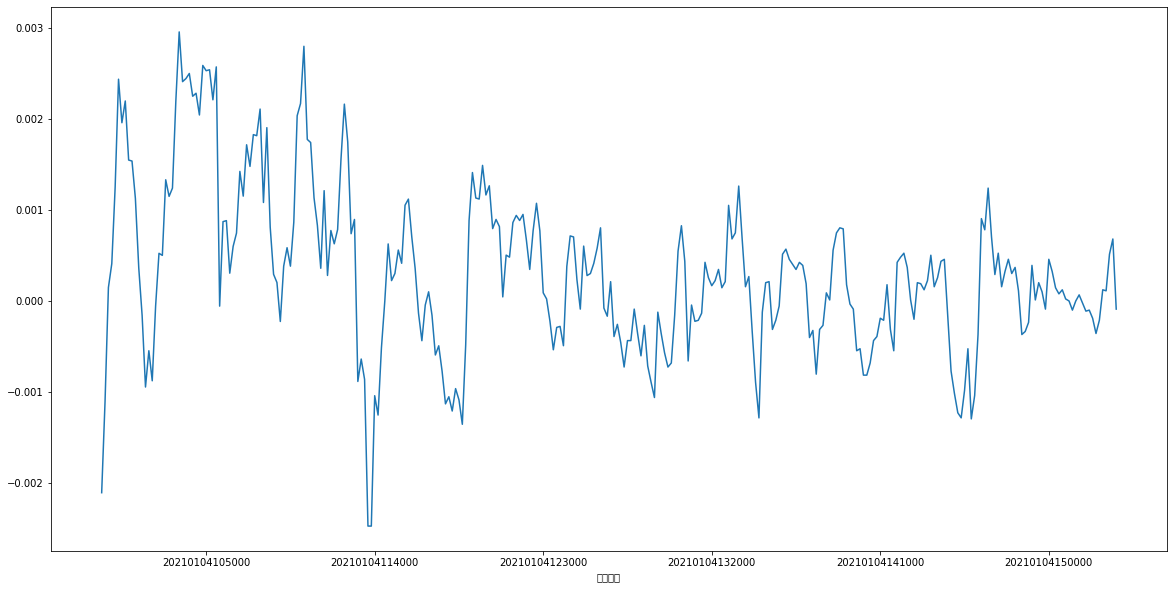

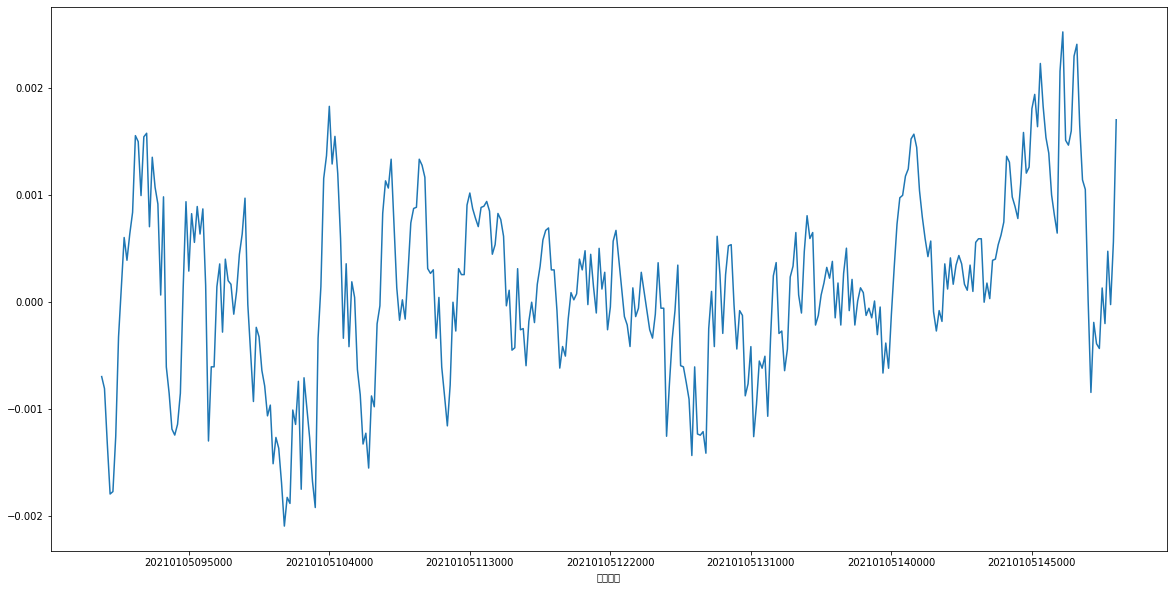

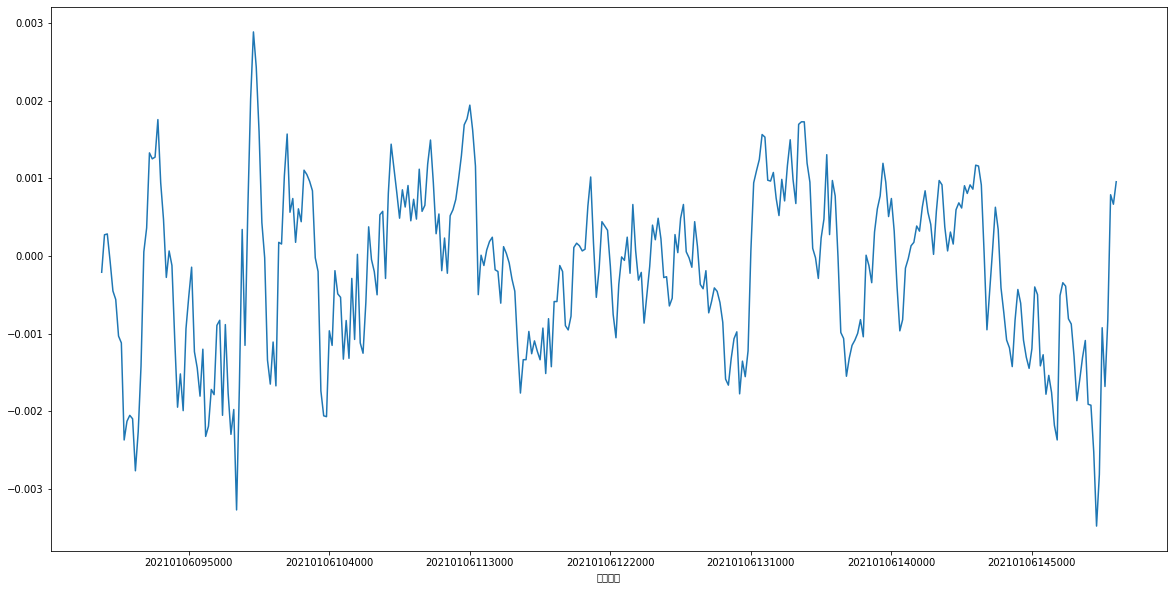

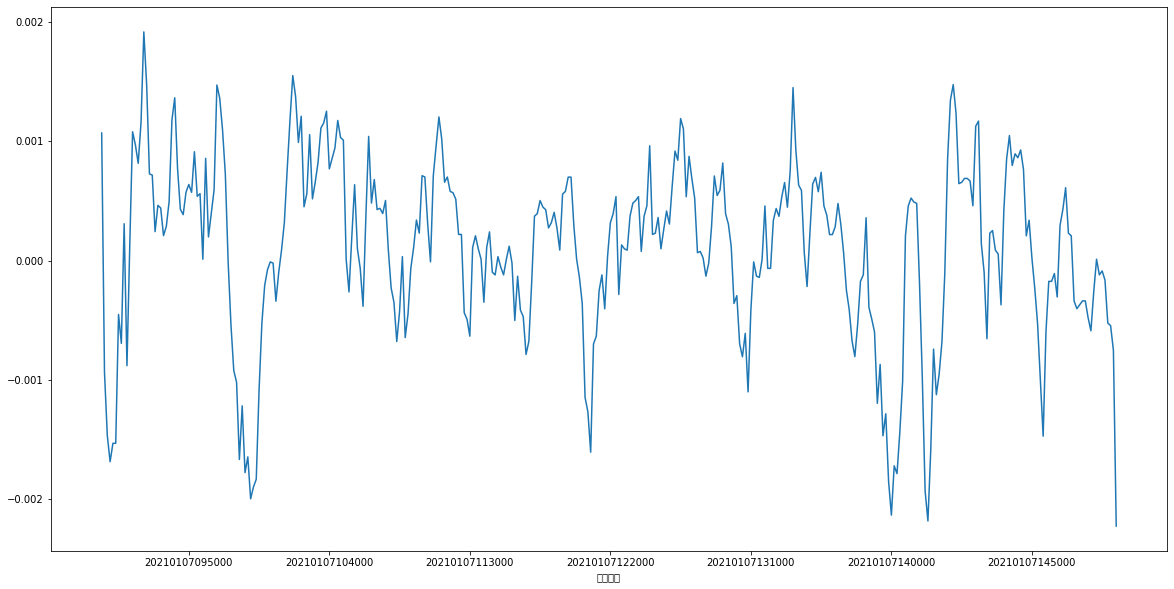

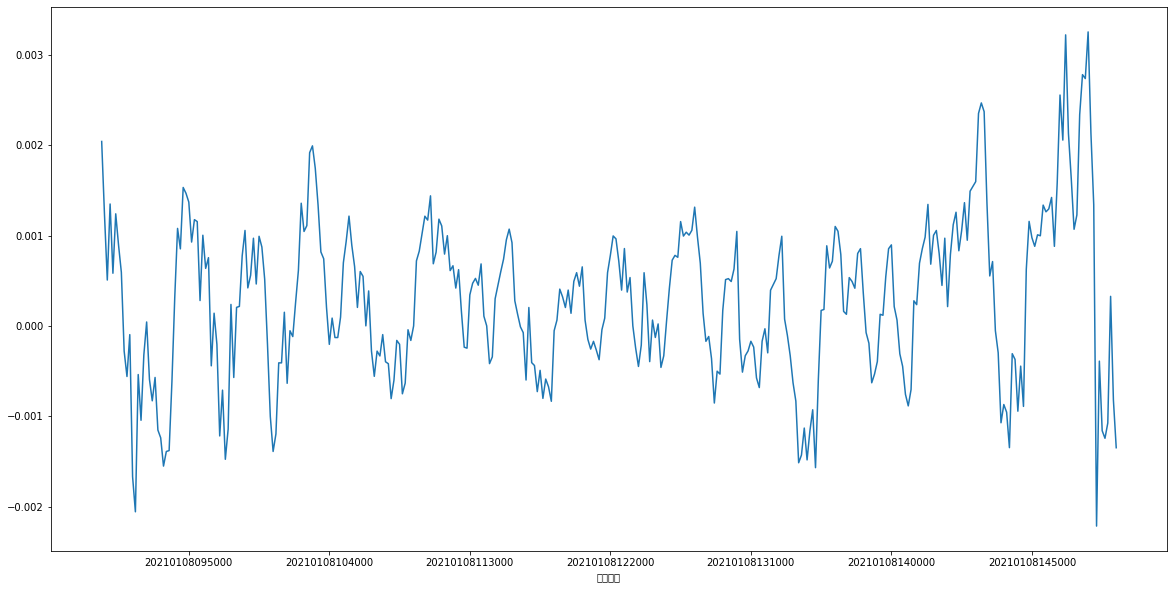

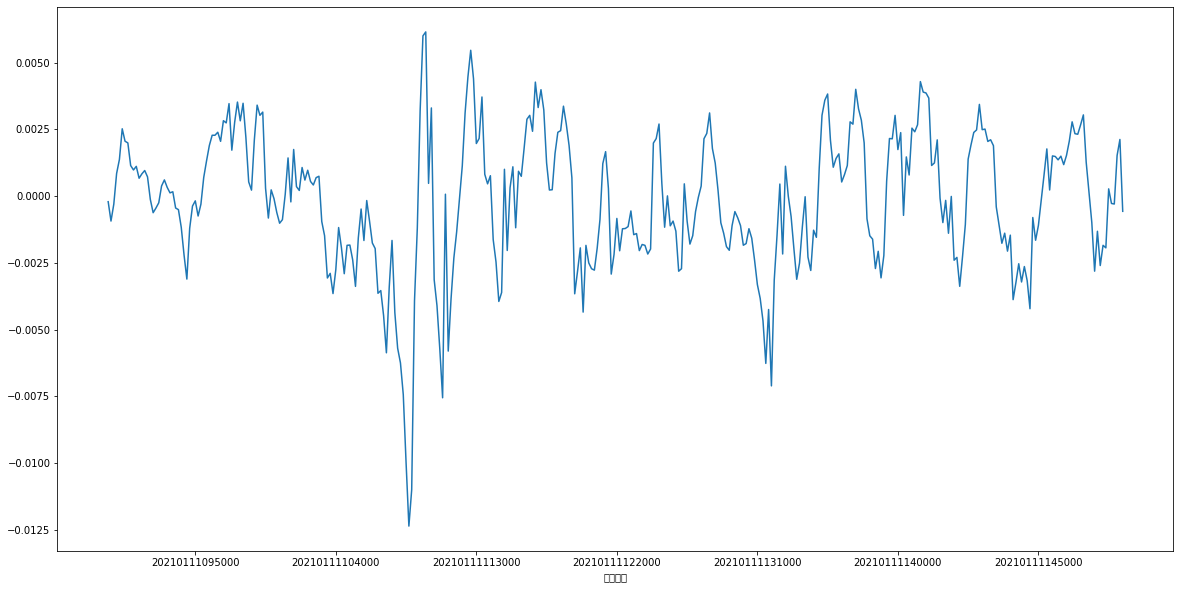

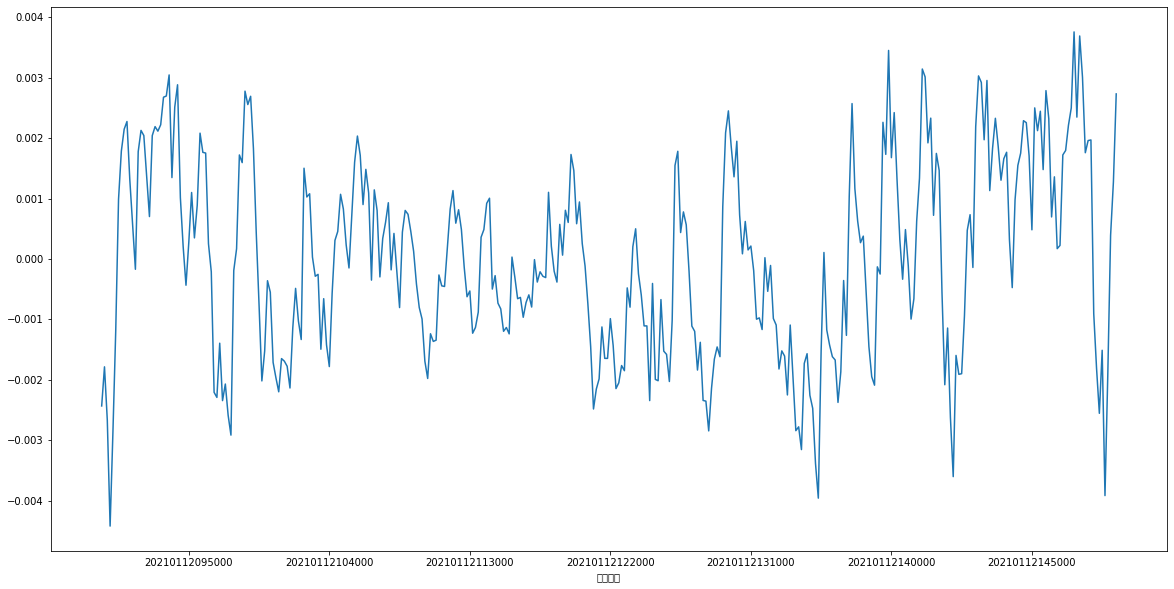

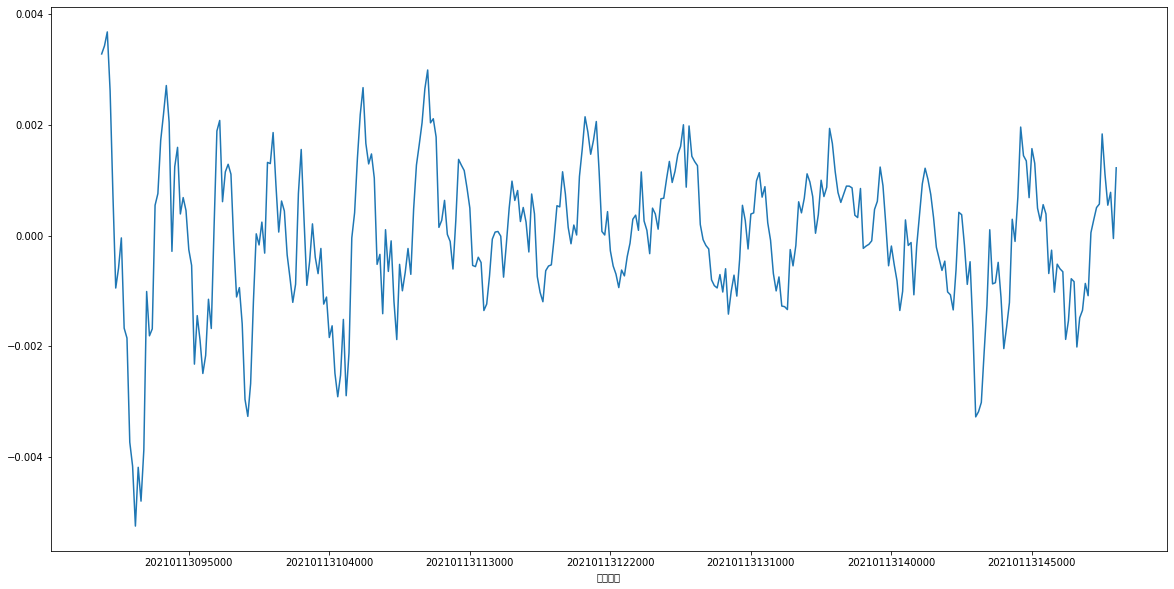

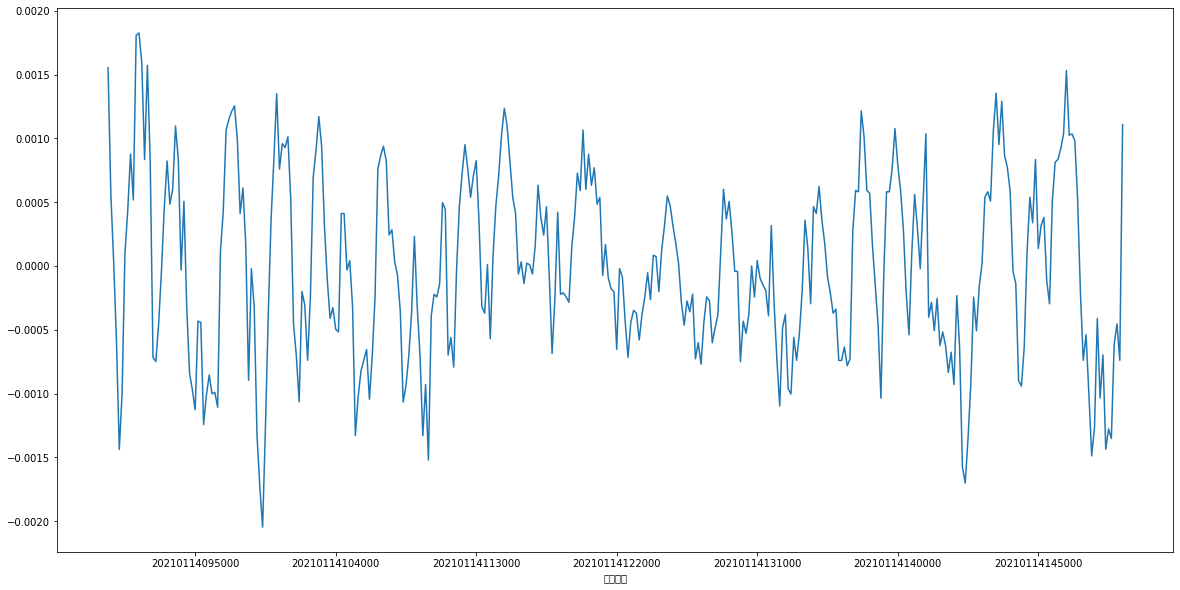

In [15]:
for date in calender[-10:]:
    plt.rcParams["figure.figsize"] = (20, 10)
    # df[date]['spread'].plot()
    # df[date]['ma60_spread'].plot()
    # temp_high = df[date]['ma60_spread'] +30
    # temp_low = df[date]['ma60_spread']-30
    # temp_high.plot(linestyle='--')
    # temp_low.plot(linestyle='--')
    # df[date]['kodex200'].plot()
    # df[date]['kodex_inv'].plot()
    # df[date]['kodex200_dayret'].plot()
    # df[date]['kodex_inv_dayret'].plot()
    df[date]['zscore'].plot()
    # plt.axhline((0.0003), color='red', linestyle='--')
    # plt.axhline((-0.0003), color='red', linestyle='--')
    plt.show()

/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 52404 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44208 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49884 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44036 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 52404 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 44208 missing from current font.
  font.set_te

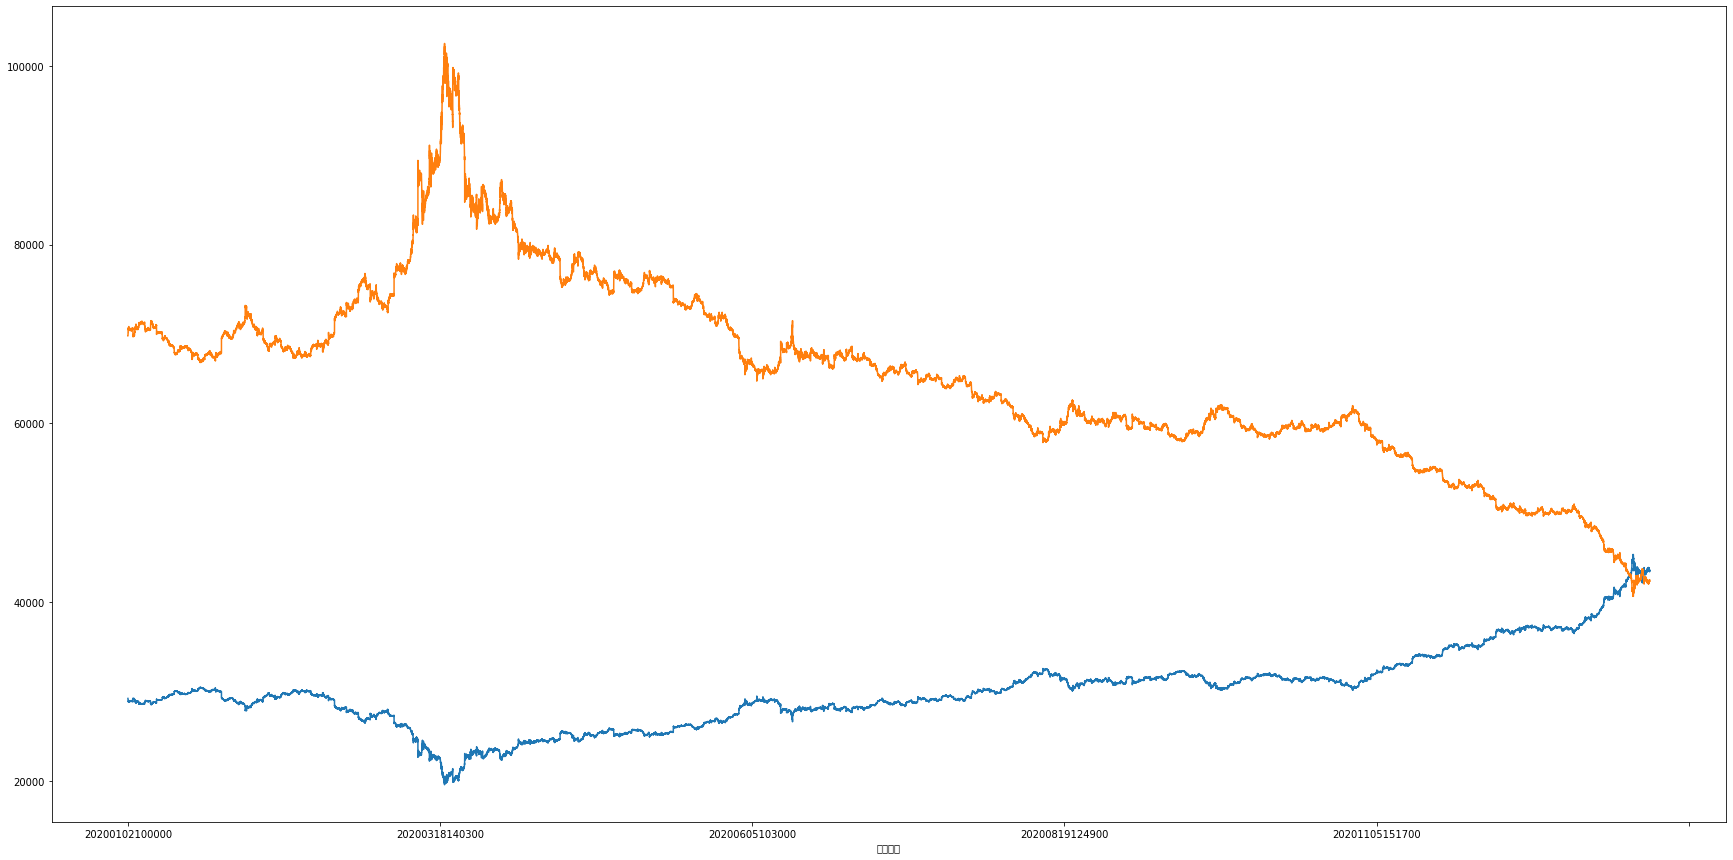

In [18]:
plt.rcParams["figure.figsize"] = (30, 15)
# temp['kodex200_cumret'].plot()
# temp['kodex_active_cumret'].plot()
# temp['kodex200_cumret'].plot()
temp['kodex200'].plot()
temp['kodex_inv'].plot()
# temp['ma30'].plot()